In [1]:
# Core
import datetime
import os
import glob
import tempfile
import sys
import pickle
import copy

# Analysis 
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging 
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
import tint.visualization
import tint.visualization_aux
from tint import animate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualization
%aimport tint.visualization_aux

In [3]:
import CPOL_func as cf
import caine_func as caf
%aimport

Modules to reload:
CPOL_func caine_func tint.visualization tint.visualization_aux

Modules to skip:



In [4]:
def test():
#     filenames = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-10 05:00'), 
#                   np.datetime64('2006-02-10 17:00'), 
#                   np.timedelta64(10, 'm'))
#     )[0]
    
    [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-08 12:00'), 
                  np.datetime64('2006-02-13 12:00'), 
                  np.timedelta64(10, 'm')), mp='thompson'
    )

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl', 
              'rb') as f:
        b_ind_set = pickle.load(f)

    # Define settings for tracking
    settings = {
        'MIN_SIZE' : [40, 400, 800], # square km
        'FIELD_THRESH' : ['convective', 20, 15], # DbZ
        'ISO_THRESH' : [10, 10, 10], # DbZ
        'GS_ALT' : 3000,
        'SEARCH_MARGIN' : 10000, # m. This is just for object matching step:
        # does not affect flow vectors.
        'FLOW_MARGIN' : 40000, # m. Margin around object over which to
        # perform phase correlation.
        'LEVELS' : np.array( # m
            [[3000, 3500], 
             [3500, 7500],
             [7500, 10000]]
        ),
        'TRACK_INTERVAL' : 0,
        'BOUNDARY_GRID_CELLS' : b_ind_set,
        'UPDRAFT_START': 3000
    }

    tracks_obj  = tint.Cell_tracks()

    for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                      'TRACK_INTERVAL', 'ISO_THRESH', 'SEARCH_MARGIN',
                      'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS', 'UPDRAFT_START'
                     ]:
        tracks_obj.params[parameter] = settings[parameter]

    # Calculate tracks
    # %lprun -T lprof0 -f get_filtered_frame_steiner tracks_obj.get_tracks(grids)
    tracks_obj.get_tracks(grids)
    #tracks_obj = cf.get_reanalysis_vars(tracks_obj)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                     + 'tracks_obj_test.pkl'.format(dt))

    with open(out_file_name, 'wb') as f:
        pickle.dump(tracks_obj, f)
        
    return tracks_obj
        
if __name__ == '__main__':
    try:
        tracks_obj = test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)
        
# print(open('lprof0', 'r').read())

Gathering files.
Calculating additional tracks properties.
Calculating system tracks.


Time elapsed: 1.5 minutes


In [4]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_com_2001_2014.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [30]:
def test():
    lon_min = 131.0 - 1.6
    lon_max = 131.0 + 1.6

    lat_max = -12.2 + 1.6
    lat_min = -12.2 - 1.6

#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2003-12-20 08:20'), 
#                   np.datetime64('2003-12-20 09:30'), 
#                   np.timedelta64(10, 'm'))
#     )

    [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-09 11:00'), 
                  np.datetime64('2006-02-09 13:00'), 
                  np.timedelta64(10, 'm')), mp='thompson'
    )
    
    tracks_obj_temp = tracks_obj
#     tracks_obj_temp.tracks = tracks_obj_temp.tracks[sub_cond]
#     tracks_obj_temp.system_tracks = tracks_obj_temp.system_tracks[sub_cond_sys]
    
#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(
#         tracks_obj_temp, '7079'
#     )

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_anim'

    animate(tracks_obj_temp, grids, out_path,
            start_datetime = start_time,
            end_datetime = end_time,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2),
            tracers=False, keep_frames=False, dpi=100, alt_low=3000,
            alt_high=9500, scan_boundary=False, wrf_winds=True, 
            line_coords=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Gathering files.
Animating from 2006-02-09T11:00 to 2006-02-09T12:50.
Plotting scan at 2006-02-09T12:50:00.
Creating GIF - may take a few minutes.


In [33]:
def test():
    uid = '1'

#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(
#         tracks_obj, uid
#     )

    lon_min = 131.0 - 2.6
    lon_max = 131.0 + 2.6

    lat_max = -12.2 + 2.6
    lat_min = -12.2 - 2.6
    
#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2003-12-20 08:20'), 
#                   np.datetime64('2003-12-20 08:30'), 
#                   np.timedelta64(10, 'm'))
#     )

    [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-09 11:10'), 
                  np.datetime64('2006-02-09 11:20'), 
                  np.timedelta64(10, 'm')), mp='thompson'
    )

    grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
    
    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_lagrangian'
    animate(tracks_obj, grids, out_path, style='updraft', uid=uid, 
            alt_low=3000, alt_high=9500, keep_frames=False, dpi=100,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2), 
            center_ud=True, wrf_winds=True, line_coords=True,
            average_along_line=False, quiver=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Gathering files.
Animating 27 frames
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 07:40:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 07:50:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 08:00:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 08:10:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 08:20:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 08:30:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 08:40:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 08:50:00.
Moving to next object frame.
Current grid at 2006-02-09T11:10:00.
Object initialises at 2006-02-09 09:00:00.
Moving to n

In [5]:
# Let's filter by tilt direction and magnitude, velocity magnitude
# and significant area.
eastward_motion = (tracks_obj.system_tracks['u_shift'] > 5)
forward_tilt = ((-45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 45))
backward_tilt = ((-135 >= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                | (tracks_obj.system_tracks['sys_rel_tilt_dir'] >= 135))
left_tilt = ((45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 135))
right_tilt = ((-135 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= -45))
# # downshear_motion = ((-45 <= tracks_obj.system_tracks['shear_rel_sys_dir'])
# #                 & (tracks_obj.system_tracks['shear_rel_sys_dir'] <= 45))
# # upshear_motion = ((-135 >= tracks_obj.system_tracks['shear_rel_sys_dir'])
# #                  | (tracks_obj.system_tracks['shear_rel_sys_dir'] >= 135))
# sig_shear_mag = (tracks_obj.system_tracks['shear_mag'] >= 2)
sig_tilt_mag = (tracks_obj.system_tracks['tilt_mag'] >= 20000)
vel_mag = np.sqrt(tracks_obj.system_tracks['u_shift']**2 
                  + tracks_obj.system_tracks['v_shift']**2)
sig_vel_mag = ((vel_mag >= 4) & (vel_mag <= 30))
eccentricity_mag = tracks_obj.system_tracks['eccentricity'] > .80
# Note for CPOL 2.5 km, total scan area is only 66052 km^2. This makes 
# traditional MCS definitions of area > 30000 km^2 difficult to apply, 
# and still coherently calculate tilt. 

small_area = tracks_obj.system_tracks['proj_area'] < 4000
large_area = tracks_obj.system_tracks['proj_area'] > 50000
sig_area = ~small_area & ~large_area

not_border = (tracks_obj.system_tracks['touch_border']*6.25 / tracks_obj.system_tracks['proj_area']) < 0.01

tracks_0 = tracks_obj.tracks[['touch_border', 'proj_area']].xs(
    0, level='level'
)
not_border_0 = (tracks_0['touch_border'] * 6.25 / tracks_0['proj_area']) < 0.01

In [20]:
# Let's find the cells that were tracked for the most frames.
sub_cond_sys = not_border_0 * eccentricity_mag
sub_cond = sub_cond_sys.append([sub_cond_sys]*2).sort_index(sort_remaining=True)
levels = np.array([0,1,2]*len(sub_cond_sys))

sub_cond = sub_cond.to_frame()
sub_cond.insert(0, 'level', levels)
sub_cond = sub_cond.reset_index()

sub_cond = sub_cond.set_index(['scan', 'time', 'level', 'uid'])
# sub_cond = sub_cond.ix[:,0]
# tracks_obj.tracks[sub_cond]
tracks_obj.system_tracks[sub_cond_sys].groupby(level='uid').size().sort_values(ascending=False)[:20]

uid
10    23
4     16
23    16
1     16
5     12
8      9
22     8
2      7
7      5
6      5
13     4
11     4
0      4
12     2
21     1
dtype: int64

In [25]:
tracks_obj.system_tracks.xs('2', level='uid')

,,grid_x,grid_y,com_x,com_y,lon,lat,u,v,mergers,u_shift,...,max,proj_area,max_alt,touch_border,x_vert_disp,y_vert_disp,tilt_mag,vel_dir,tilt_dir,sys_rel_tilt_dir
scan,time,,,,,,,,,,,,,,,,,,,,,
142,2006-02-09 11:40:00,141186.4,-62711.9,141716.8,-62598.2,132.35230,-12.79520,NaN,NaN,{},-5.208,...,99.24,950.00,9.5,17,-1936.4,-2576.6,3223.122,149.035,-126.926,84.039
143,2006-02-09 11:50:00,140322.6,-46290.3,140999.9,-46863.3,132.34498,-12.65374,NaN,NaN,{},-6.250,...,101.24,1262.50,9.5,25,-2221.5,-13928.3,14104.347,150.947,-99.062,109.991
144,2006-02-09 12:00:00,136609.2,-51982.8,137322.3,-50891.9,132.31126,-12.69013,-5.402,6.979,{},-5.417,...,102.66,1637.50,9.5,28,95.9,-5609.4,5610.220,139.767,-89.021,131.212
145,2006-02-09 12:10:00,133203.9,-46043.7,133915.6,-45146.9,132.27961,-12.63861,-6.687,2.506,{},-5.000,...,101.33,1975.00,9.5,31,1512.7,-11324.7,11425.283,135.000,-82.392,142.608
146,2006-02-09 12:20:00,128221.2,-45961.5,129393.2,-44319.7,132.23789,-12.63135,-4.122,11.505,{},-5.000,...,102.84,2118.75,9.5,28,3580.3,-8643.3,9355.489,135.000,-67.499,157.501
147,2006-02-09 12:30:00,124275.0,-40275.0,125206.8,-38809.8,132.19909,-12.58197,-3.352,11.110,{},-4.167,...,104.02,2262.50,9.5,28,3863.7,-12580.8,13160.726,129.808,-72.928,157.264
148,2006-02-09 12:40:00,126717.6,-24370.2,126567.6,-24479.3,132.21105,-12.45305,-2.902,11.352,{},-4.167,...,104.23,2612.50,9.5,34,-459.9,-19981.7,19986.992,129.808,-91.318,138.874
149,2006-02-09 12:50:00,125159.2,-19379.0,125805.1,-18501.0,132.20379,-12.39932,-0.907,15.412,{},-5.000,...,104.37,3100.00,9.5,35,-1137.8,-16271.0,16310.734,140.192,-94.000,125.808
150,2006-02-09 13:00:00,121256.8,-18715.8,122152.2,-17291.1,132.17011,-12.38858,-3.639,9.882,{},-5.000,...,105.34,3487.50,9.5,35,-17.4,-10523.6,10523.614,140.192,-90.095,129.713


# Calculate Some Statistics

## PS, TS, LS Breakdown

In [24]:
subset_logic = sig_area & not_border & not_border_0 & sig_vel_mag & sig_tilt_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
# sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS, totals] = [np.zeros(100) for i in range(4)]

for i in sub_uids:
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']
    
    # Break down sig_tilt categories
    forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
    backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        TS[bwd_inds] += 1
        LS[fwd_inds] += 1
        PS[pll_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

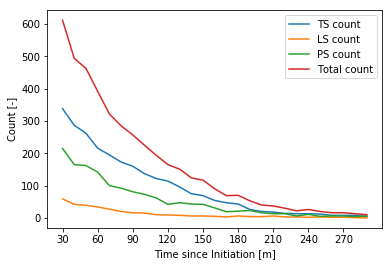

In [25]:
plt.plot(np.arange(30,300,10), TS[3:30], label='TS count')
plt.plot(np.arange(30,300,10), LS[3:30], label='LS count')
plt.plot(np.arange(30,300,10), PS[3:30], label='PS count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/counts.png')

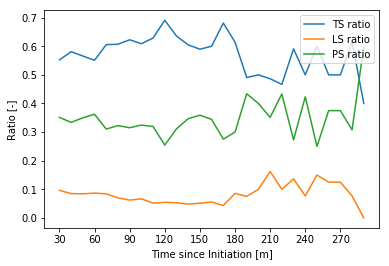

In [27]:
plt.plot(np.arange(30,300,10), (TS/totals)[3:30], label='TS ratio')
plt.plot(np.arange(30,300,10), (LS/totals)[3:30], label='LS ratio')
plt.plot(np.arange(30,300,10), (PS/totals)[3:30], label='PS ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/ratios.png')

## Filtered versus Unfiltered

In [ ]:
subset_logic = sig_area & not_border & not_border_0
sub_tracks = tracks_obj.system_tracks[subset_logic]
# sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS, no_tilt, totals] = [np.zeros(100) for i in range(5)]

for i in sub_uids:
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']
    
    # Define threshhold for tilt to be considered
    sig_tilt_mag = (obj['tilt_mag'] >= 20000)
    vel_mag = np.sqrt(obj['u_shift']**2 + obj['v_shift']**2)
    sig_vel_mag = ((vel_mag >= 4) & (vel_mag <= 30))
#     eccentricity_mag = obj['eccentricity'] > .80

    sig_tilt = sig_tilt_mag & sig_vel_mag
    
    # Break down sig_tilt categories
    forward_tilt = ((-45 <= tilts) & (tilts <= 45)) & sig_tilt
    backward_tilt = ((-135 >= tilts) | (tilts >= 135)) & sig_tilt

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt & sig_tilt).flatten().tolist()].tolist()
    nt_inds = scan_label[np.argwhere(~sig_tilt).flatten().tolist()].tolist()
    totals_inds = scan_label.tolist()
    
    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        TS[bwd_inds] += 1
        LS[fwd_inds] += 1
        PS[pll_inds] += 1
        no_tilt[nt_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

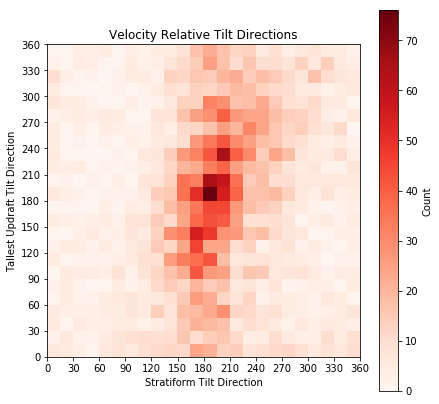

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

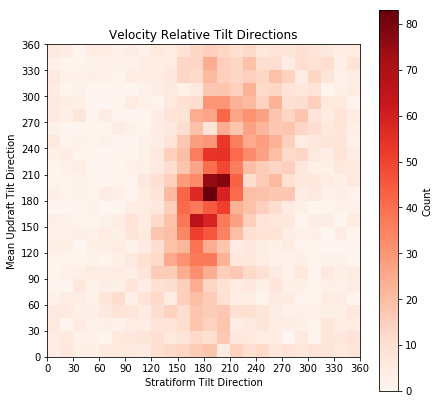

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')